In [1]:
import os
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(1)
device="cuda"

In [2]:
#source: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
dat = pd.read_csv('./mnist_train.csv')

In [3]:
class Discriminator(nn.Module):
    def __init__(self, dim = 32):
        super().__init__()
        self.dim = dim
        self.conv = nn.Sequential(
            nn.Conv2d(1, dim, 4, 2, 1),
            #nn.BatchNorm2d(dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Conv2d(dim, dim*2, 3, 1, 1),
            nn.BatchNorm2d(dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(dim*2, dim*4, 3, 1, 1),
            nn.BatchNorm2d(dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(dim*4, dim*8, 4, 2, 1),
            nn.BatchNorm2d(dim*8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.fc = nn.Linear(dim*8*7*7, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv(x)
        x = x.view(-1, self.dim*8*7*7)
        x = self.fc(x)
        
        #x = torch.sigmoid(x)
        
        return x.view(-1)
    

In [4]:

class Generator(nn.Module):
    
    def __init__(self, dim = 32, zdim = 100):
        super().__init__()
        self.dim = dim
        self.fc = nn.Linear(zdim, dim*8*7*7)
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(dim*8, dim*4, 4, 2, 1),
            nn.BatchNorm2d(dim*4),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.ConvTranspose2d(dim*4, dim*2, 3, 1, 1),
            nn.BatchNorm2d(dim*2),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(dim*2, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(dim, 1, 4, 2, 1),
            #nn.BatchNorm2d(1),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim*8, 7, 7)
        x = self.conv(x)
        
        return x  

In [5]:
def generate_images(val, batchsize=32, zdim=100, epochs=10, verbose=1):
    start=timer()
    train = torch.Tensor(dat[dat['label'] == val].values[:,1:].reshape(-1, 28, 28)/255)*2-1
    dataloader = DataLoader(train, batch_size = batchsize, shuffle = True)

    dis = Discriminator().to(device)
    gen = Generator().to(device)
    Loss = nn.BCEWithLogitsLoss()
    dis_optimizer = optim.Adam(dis.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    gen_optimizer = optim.Adam(gen.parameters(), lr = 0.0002, betas = (0.5, 0.999))

    
    dis_loss = np.zeros(epochs)
    gen_loss = np.zeros(epochs)

    fixed_samples = torch.randn(9, zdim)
    fixed_samples = fixed_samples.to(device)
    print("preprocessing time =", timer()-start)
    
    for epoch in range(epochs):

        for x in dataloader:
            dis.train()
            gen.train()
            noise = torch.randn(x.shape[0], zdim).to(device).float()

            dis_optimizer.zero_grad()
            y_real = dis(x.to(device).float())
            fake_imgs = gen(noise).detach()
            y_fake = dis(fake_imgs.float())

            loss = Loss(y_real, torch.ones(x.shape[0]).to(device)) + Loss(y_fake, torch.zeros(x.shape[0]).to(device))
            dis_loss[epoch] += loss.item()
            loss.backward()
            dis_optimizer.step()  


            gen_optimizer.zero_grad()
            fake_imgs = gen(noise)
            y = dis(fake_imgs.float())

            loss = Loss(y, torch.ones(x.shape[0]).to(device))
            gen_loss[epoch] += loss.item()
            loss.backward()
            gen_optimizer.step()
        
        dis_loss/=len(dataloader)
        gen_loss/=len(dataloader)
        
        if (verbose>=2 or (verbose==1 and epoch==epochs-1)):
            gen.eval()     
            samples = gen(fixed_samples.float())

            fig, axes = plt.subplots(3,3)
            for i in range(9):
                img = samples[i].cpu().detach()[0]
                axes[i//3,i%3].imshow(img, cmap='Greys_r')
        
        if (verbose>=1):
            print("Epoch", epoch, "time =", timer()-start, 
                  "Dis loss =", dis_loss[epoch],
                  "Gen loss =", gen_loss[epoch])    
    
    if (verbose>=2):
        plt.clf()
        plt.plot(range(epochs),dis_loss,label="discriminator loss")
        plt.plot(range(epochs),gen_loss,label="generator loss")
        plt.title("loss plot")
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.ylim([0,0.1+np.max([dis_loss,gen_loss])])
        plt.show()
        


preprocessing time = 0.2121671000495553
Epoch 0 time = 3.6422428999794647 Dis loss = 0.3114438025901715 Gen loss = 3.4030759833672994
Epoch 1 time = 6.16332210006658 Dis loss = 0.6784532299285294 Gen loss = 2.5234349882730873
Epoch 2 time = 8.68349930003751 Dis loss = 0.838957497830032 Gen loss = 2.1570002848422654
Epoch 3 time = 11.276596799958497 Dis loss = 0.9348445545922044 Gen loss = 1.7722680549467764
Epoch 4 time = 14.080173800000921 Dis loss = 1.0352893305081192 Gen loss = 1.5799581536682703
Epoch 5 time = 16.70521980000194 Dis loss = 1.0679099192862869 Gen loss = 1.4304699848095577
Epoch 6 time = 19.268723399960436 Dis loss = 1.105244440737591 Gen loss = 1.341899908678506
Epoch 7 time = 21.802384400041774 Dis loss = 1.1156921421968808 Gen loss = 1.2659540222857588
Epoch 8 time = 24.33496190002188 Dis loss = 1.1210206301622494 Gen loss = 1.2575721708677148
Epoch 9 time = 27.04979399999138 Dis loss = 1.1566157600572031 Gen loss = 1.2485946178115823
preprocessing time = 0.0845597

Epoch 5 time = 18.75552579993382 Dis loss = 0.9217976968470818 Gen loss = 1.8931542211543015
Epoch 6 time = 21.622139999992214 Dis loss = 0.953171551553278 Gen loss = 1.7473377389986007
Epoch 7 time = 24.425558599992655 Dis loss = 0.9630214278815222 Gen loss = 1.6321692958555587
Epoch 8 time = 27.153558199992403 Dis loss = 0.9649973550780875 Gen loss = 1.6016013045779993
Epoch 9 time = 30.07470909995027 Dis loss = 1.0106666136960514 Gen loss = 1.494068654834247
preprocessing time = 0.07113090006168932
Epoch 0 time = 3.0356187999714166 Dis loss = 0.20541798589771154 Gen loss = 4.127569289617641
Epoch 1 time = 6.184152900008485 Dis loss = 0.5902668787266618 Gen loss = 3.0591308838257225
Epoch 2 time = 9.328057100065053 Dis loss = 0.7312117701256147 Gen loss = 2.516936256680437
Epoch 3 time = 12.382627099985257 Dis loss = 0.7967743125333581 Gen loss = 2.294181704521179
Epoch 4 time = 15.357503400067799 Dis loss = 0.82556391355171 Gen loss = 2.08208252409453
Epoch 5 time = 18.1332878000102

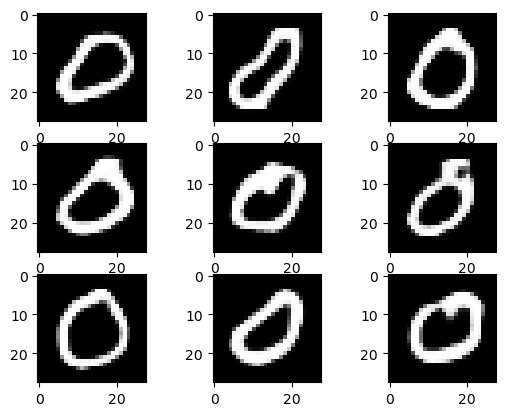

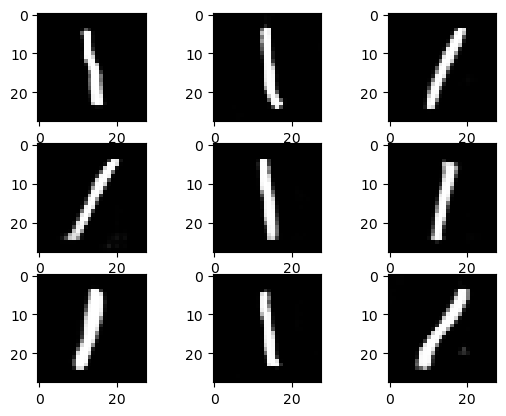

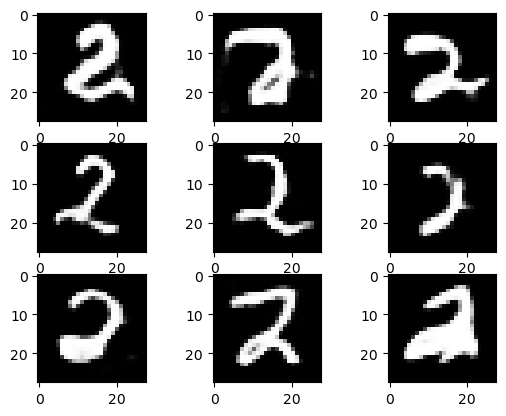

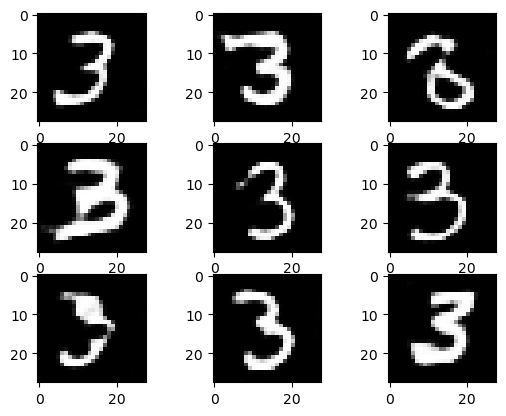

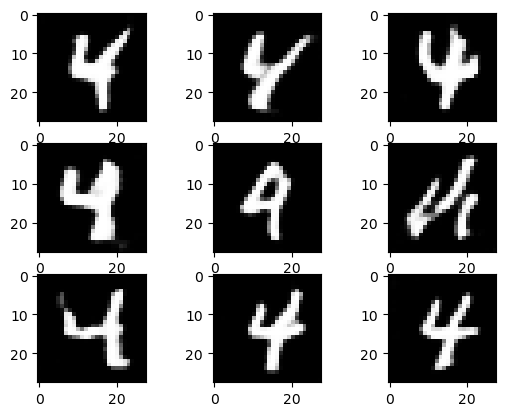

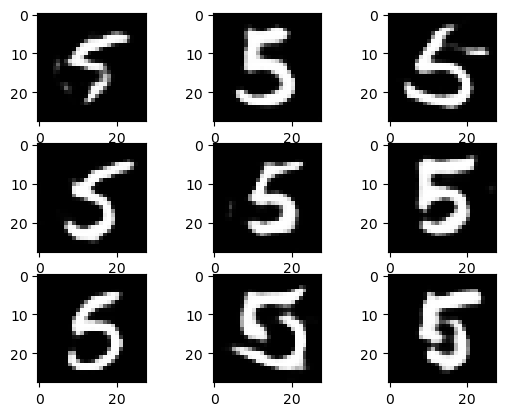

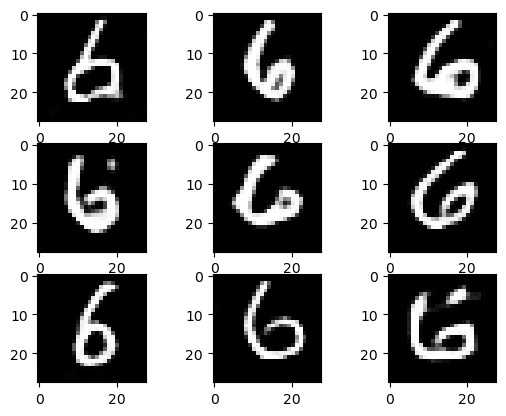

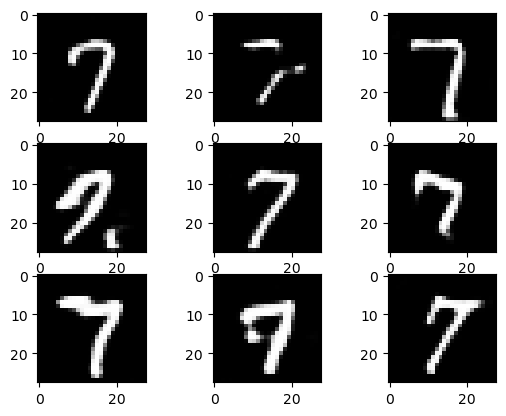

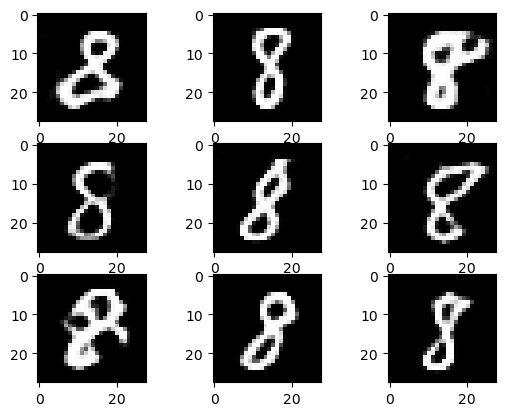

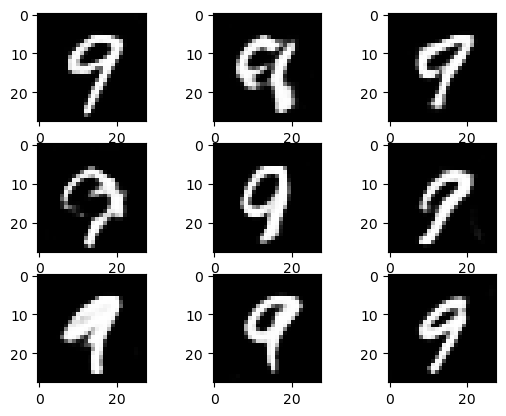

In [6]:
torch.manual_seed(1)
for i in range(10):
    generate_images(i)